# Wind data corruption issue

This notebook investigates an issue with some of the re-stacked 20km WRF wind data files hosted on AWS. Run by Kyle on Atlas on 2/23/22.

## The issue

Peter demonstrated this issue with timestep 976 in `u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc`, sharing a visualization of this slice of data which shows a large swath of 0 values for much of the grid. See if this issue can be re-created:

## Download the data

Link for the above file: [http://wrf-ak-ar5.s3.amazonaws.com/hourly/NCAR-CCSM4/rcp85/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc](http://wrf-ak-ar5.s3.amazonaws.com/hourly/NCAR-CCSM4/rcp85/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc). 1.7GB!

In [12]:
import requests
from tqdm import tqdm

url = "http://wrf-ak-ar5.s3.amazonaws.com/hourly/NCAR-CCSM4/rcp85/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc"
test_fp = "/atlas_scratch/kmredilla/WRF/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071_suspect.nc"

response = requests.get(url, stream=True)
total_size_in_bytes= int(response.headers.get("content-length", 0))
block_size = 1024 #1 Kibibyte
progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
with open(test_fp, "wb") as file:
    for data in response.iter_content(block_size):
        progress_bar.update(len(data))
        file.write(data)
progress_bar.close()
if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
    print("ERROR, something went wrong")
    
# thanks https://stackoverflow.com/a/37573701/11417211

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.86G/1.86G [01:25<00:00, 21.8MiB/s]


In [17]:
import xarray as xr

test_ds = xr.open_dataset(test_fp)

In [44]:
# there might be something goin on here, run some stuff below to see where things get hung up

try:
    test_ds["u10"].sel(time=test_ds.time.values[974]).plot()
except RuntimeError:
    print("This error happens at slice 974 and none before it, plus at least some after it")

This error happens at slice 974 and none before it, plus at least some after it


see


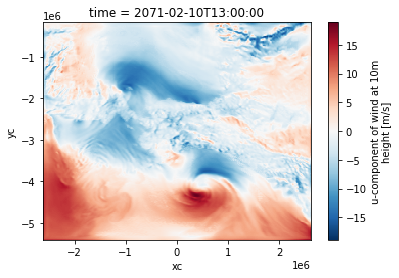

In [46]:
# there might be something goin on here, run some stuff below to see where things get hung up
test_ds["u10"].sel(time=test_ds.time.values[973]).plot()
print("see")

In [47]:
try:
    test_ds["u10"].sel(time=test_ds.time.values[975]).plot()
except RuntimeError:
    print("975 fail")

975 fail


In [48]:
try:
    test_ds["u10"].sel(time=test_ds.time.values[976]).plot()
except RuntimeError:
    print("976 fail, the slice Peter shared")

976 fail, the slice Peter shared


So, this file is totally corrupt. Is this file corrupt on RCS storage?

In [55]:
ls -l /rcs/project_data/wrf_data/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc

ls: cannot access /rcs/project_data/wrf_data/hourly_fix/u10/u10_hourly_wrf_NCAR-CCSM4_rcp85_2071.nc: No such file or directory


Not available. What about the non-"fixed" version? Looks like this one is available:

In [7]:
test_ds = xr.open_dataset("/rcs/project_data/wrf_data/wind-issue/hourly/u10/U10_wrf_hourly_ccsm_rcp85_2071.nc")

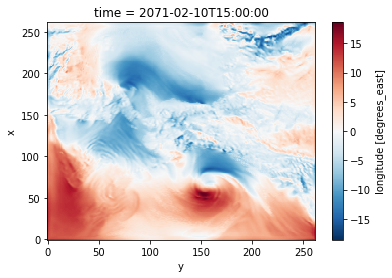

In [10]:
test_ds["U10"].sel(time=test_ds.time.values[975]).plot()

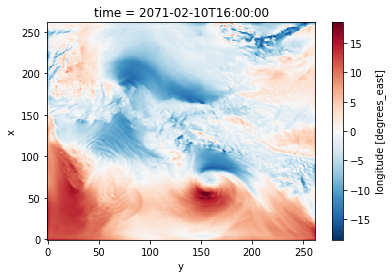

In [11]:
test_ds["U10"].sel(time=test_ds.time.values[976]).plot()

Okay, so the non-"fixed" data is does not have this same problem.

## Summary

So this could potentially be fixed by just re-"improving" the re-stacked data. However, I think the best move for now is to re-stack all of the data as necessary to include the lat / lon variables since a number of re-stacked files were found to be corrupt in [`./include_latlon.ipynb`](include_latlon.ipynb). Then the full suite of quality checks can be made before uploading to AWS. 